In [18]:
import math
import copy
import os
import sys
import json
import pickle
import random
import argparse

from functools import partial
from collections import OrderedDict
from typing import Optional, Callable
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
HEIGHT = 30
WIDTH = 30
inputPath = '/kaggle/input/gtsrb-german-traffic-sign'

## EDA

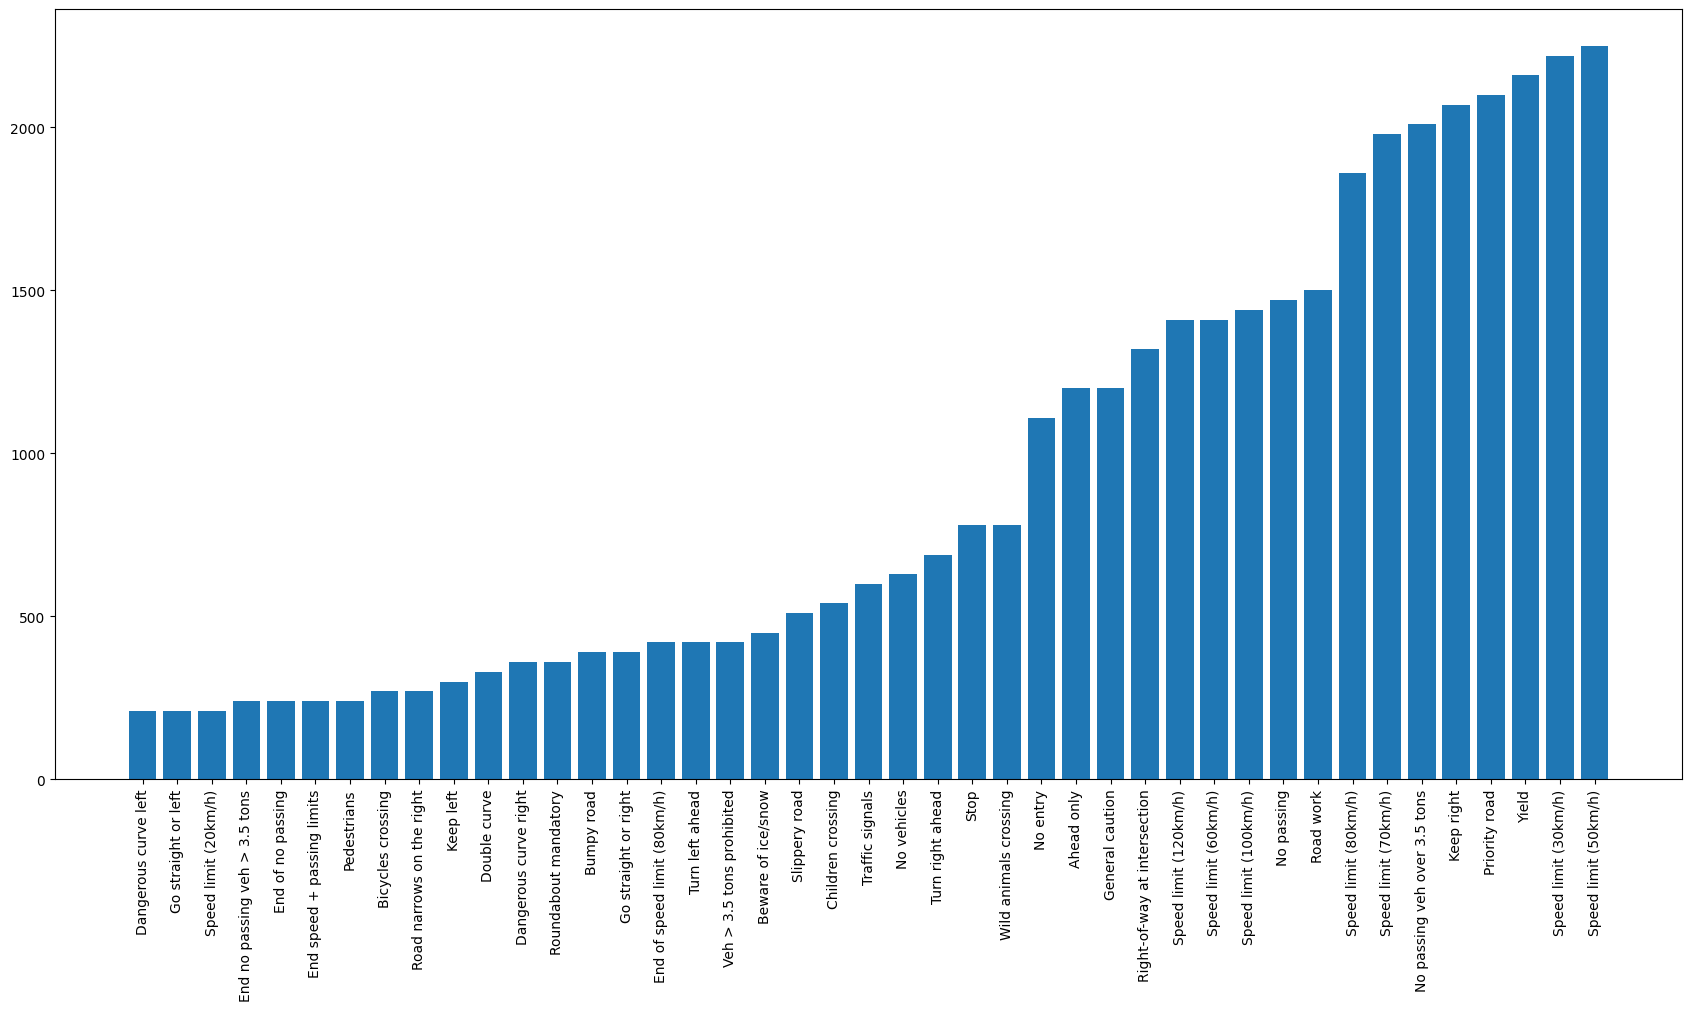

In [19]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

trainFolder = 'archive/Train'
trainFolders = os.listdir(trainFolder)

trainNumber = []
classNum = []

for folder in trainFolders:
    trainFiles = os.listdir(trainFolder + '/' + folder)
    trainNumber.append(len(trainFiles))
    classNum.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipList = zip(trainNumber, classNum)
sortedPairs = sorted(zipList)
tuples = zip(*sortedPairs)
trainNumber, classNum = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(classNum, trainNumber)
plt.xticks(classNum, rotation='vertical')
plt.show()

## Resampling

/Users/a040/opt/anaconda3/lib/python3.9/site-packages/imblearn/under_sampling/_prototype_generation/_cluster_centroids.py:190: ConvergenceWarning: Number of distinct clusters (410) found smaller than n_clusters (459). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))


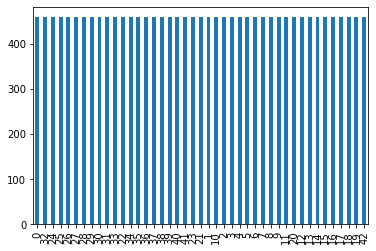

In [4]:
trainData = pd.read_csv('archive/Train.csv', usecols=['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId'])

features = []
for feature in trainData.columns:
    if feature != 'ClassId':
        features.append(feature)
X = trainData[features]
y = trainData['ClassId']

X_train, X_test, y_train, y_test = train_test_split(X, y)

count = y_train.value_counts()

n_samples = int(count.median())

def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

from imblearn.under_sampling import ClusterCentroids
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train,y_train,n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)
y_bal.value_counts().plot.bar()
plt.show()



## Efficient Net V2

In [20]:
# Set up data transform
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 4
dataset = ImageFolder(root=trainFolder, transform=transform)
print(f'Dataset loaded. Each image is transformed to a tensor of size {dataset[0][0].shape}.')
n_train = int(len(dataset) * 0.8)
n_test = len(dataset) - n_train
trainset, testset = torch.utils.data.random_split(dataset, [n_train, n_test])
print(f'Splitting data into trainset of size {len(trainset)} and testset of size {len(testset)}')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
print(trainloader)
print(trainset)
print(torch.version.cuda)

print(torch.cuda.is_available())

Dataset loaded. Each image is transformed to a tensor of size torch.Size([3, 299, 299]).
Splitting data into trainset of size 31367 and testset of size 7842
None
False


In [21]:
import torchvision
# .models as models
# efficientnetV2 = models.efficientnet_v2_s(pretrained=True)
# efficientnetV2 = efficientnetV2.to('cuda')

print(torchvision.__version__)

0.14.0


In [11]:
class MyDataSet(Dataset):
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform   # 在train里有定义，指的是图片预处理的方式，是按照train方式还是validation方式

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':
            raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]

        if self.transform is not None:  # 把图片预处理，按照train方式或者validation方式，具体的在train里
            img = self.transform(img)   

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

NameError: name 'Dataset' is not defined

In [12]:
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root)

    # 遍历文件夹，一个文件夹对应一个类别
    traffic_sign_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证各平台顺序一致
    traffic_sign_class.sort()
    # 生成类别名称以及对应的数字索引
    class_indices = dict((k, v) for v, k in enumerate(traffic_sign_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in traffic_sign_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 排序，保证各平台顺序一致
        images.sort()
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."

    plot_image = False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(traffic_sign_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(traffic_sign_class)), traffic_sign_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('traffic_sign class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label


def plot_data_loader_image(data_loader):
    batch_size = data_loader.batch_size
    plot_num = min(batch_size, 4)

    json_path = './class_indices.json'
    assert os.path.exists(json_path), json_path + " does not exist."
    json_file = open(json_path, 'r')
    class_indices = json.load(json_file)

    for data in data_loader:
        images, labels = data
        for i in range(plot_num):
            # [C, H, W] -> [H, W, C]
            img = images[i].numpy().transpose(1, 2, 0)
            # 反Normalize操作
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
            label = labels[i].item()
            plt.subplot(1, plot_num, i+1)
            plt.xlabel(class_indices[str(label)])
            plt.xticks([])  # 去掉x轴的刻度
            plt.yticks([])  # 去掉y轴的刻度
            plt.imshow(img.astype('uint8'))
        plt.show()


def write_pickle(list_info: list, file_name: str):
    with open(file_name, 'wb') as f:
        pickle.dump(list_info, f)


def read_pickle(file_name: str) -> list:
    with open(file_name, 'rb') as f:
        info_list = pickle.load(f)
        return info_list


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    mean_loss = torch.zeros(1).to(device)
    optimizer.zero_grad()

    data_loader = tqdm(data_loader, file=sys.stdout)

    for step, data in enumerate(data_loader):
        images, labels = data

        pred = model(images.to(device))

        loss = loss_function(pred, labels.to(device))
        loss.backward()
        mean_loss = (mean_loss * step + loss.detach()) / (step + 1)  # update mean losses

        data_loader.desc = "[epoch {}] mean loss {}".format(epoch, round(mean_loss.item(), 3))

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return mean_loss.item()


@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()

    # 验证样本总个数
    total_num = len(data_loader.dataset)

    # 用于存储预测正确的样本个数
    sum_num = torch.zeros(1).to(device)

    data_loader = tqdm(data_loader, file=sys.stdout)

    for step, data in enumerate(data_loader):
        images, labels = data
        pred = model(images.to(device))
        pred = torch.max(pred, dim=1)[1]
        sum_num += torch.eq(pred, labels.to(device)).sum()

    return sum_num.item() / total_num

In [15]:
def main(args):
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")
    print('device是啥:',device)
    print('args是啥!!!',args)
    print('Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/')
    tb_writer = SummaryWriter()
    if os.path.exists("./weights") is False:
        os.makedirs("./weights")

    train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(args.data_path)

    img_size = {"B0": 224,
                "B1": 240,
                "B2": 260,
                "B3": 300,
                "B4": 380,
                "B5": 456,
                "B6": 528,
                "B7": 600}
    num_model = "B0"

    data_transform = {        # 输入图像预处理！！
        "train": transforms.Compose([transforms.RandomResizedCrop(img_size[num_model]),  # 在训练阶段把输入的图像转换成224*224的分辨率
                                     transforms.RandomHorizontalFlip(),   # 以特定的概率让图片水平翻转，为了增强训练集，增强训练效果，概率是0.5
                                     transforms.ToTensor(), #把像素归一化，从[0,255]变成[0,1]， 并且把图像（矩阵）从[H*W*C]的形式变成[C*H*W]
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]), # 前三个是均值，后三个是标准差。目的是为了将上一步的[0,1]变成[-1,1]，降低偏置bias，提高收敛的速度
        "val": transforms.Compose([transforms.Resize(img_size[num_model]),               # 在validation阶段的输入图像换成224*224的分辨率
                                   transforms.CenterCrop(img_size[num_model]),    # 中心剪裁，以中心为原点，剪出特定的图像大小
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    # 实例化训练数据集
    train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                              transform=data_transform["train"])

    # 实例化验证数据集
    val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

    batch_size = args.batch_size
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=nw,
                                               collate_fn=train_dataset.collate_fn)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=val_dataset.collate_fn)

    # 如果存在预训练权重则载入
    model = efficientnet_b0(num_classes=args.num_classes).to(device)
    if args.weights != "":
        if os.path.exists(args.weights):
            weights_dict = torch.load(args.weights, map_location=device)
            load_weights_dict = {k: v for k, v in weights_dict.items()
                                 if model.state_dict()[k].numel() == v.numel()}
            print(model.load_state_dict(load_weights_dict, strict=False))
        else:
            raise FileNotFoundError("not found weights file: {}".format(args.weights))

    # 是否冻结权重
    if args.freeze_layers:
        for name, para in model.named_parameters():
            # 除最后一个卷积层和全连接层外，其他权重全部冻结
            if ("features.top" not in name) and ("classifier" not in name):
                para.requires_grad_(False)
            else:
                print("training {}".format(name))

    pg = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(pg, lr=args.lr, momentum=0.9, weight_decay=1E-4)
    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: ((1 + math.cos(x * math.pi / args.epochs)) / 2) * (1 - args.lrf) + args.lrf  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

    for epoch in range(args.epochs):
        # train
        mean_loss = train_one_epoch(model=model,
                                    optimizer=optimizer,
                                    data_loader=train_loader,
                                    device=device,
                                    epoch=epoch)

        scheduler.step()

        # validate
        acc = evaluate(model=model,
                       data_loader=val_loader,
                       device=device)
        print("[epoch {}] accuracy: {}".format(epoch, round(acc, 3)))
        tags = ["loss", "accuracy", "learning_rate"]
        tb_writer.add_scalar(tags[0], mean_loss, epoch)
        tb_writer.add_scalar(tags[1], acc, epoch)
        tb_writer.add_scalar(tags[2], optimizer.param_groups[0]["lr"], epoch)

        torch.save(model.state_dict(), "./weights/model-{}.pth".format(epoch))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_classes', type=int, default=43)
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--batch-size', type=int, default=32)
    parser.add_argument('--lr', type=float, default=0.01)
    parser.add_argument('--lrf', type=float, default=0.01)

    # 数据集所在根目录
    parser.add_argument('--data-path', type=str,
                        default="../input/gtsrb-german-traffic-sign/Train")

    # download model weights
    parser.add_argument('--weights', type=str, default='../input/efficientnet/efficientnetb0.pth',
                        help='initial weights path')
    parser.add_argument('--freeze-layers', type=bool, default=False)
    parser.add_argument('--device', default='cuda:0', help='device id (i.e. 0 or 0,1 or cpu)')

    opt = parser.parse_args(args=[])

    main(opt)

device是啥: cpu
args是啥!!! Namespace(num_classes=43, epochs=30, batch_size=32, lr=0.01, lrf=0.01, data_path='../input/gtsrb-german-traffic-sign/Train', weights='../input/efficientnet/efficientnetb0.pth', freeze_layers=False, device='cuda:0')
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/


AssertionError: dataset root: ../input/gtsrb-german-traffic-sign/Train does not exist.